In [23]:
import glob
import os 
import itertools

from collections import defaultdict
from typing import Sequence, Union

import scanpy as sc
import anndata
import pandas as pd

import numpy as np
import scipy.sparse
import scipy.stats as st

import sklearn.preprocessing

from sklearn.metrics import mean_squared_error, log_loss, precision_recall_curve
from sklearn.metrics.cluster import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_random_state

import molecular_cross_validation.util as ut
from molecular_cross_validation.mcv_sweep import GridSearchMCV, poisson_nll_loss

%matplotlib inline
import matplotlib.pyplot as plt

seed = sum(map(ord, "differential_expression"))

In [17]:
import array_mannwhitneyu

In [36]:
# the basic diffusion algorithm, for a given parameter setting
def diffusion(
    umis: np.ndarray,
    time_steps: int,
    n_components: int,
    n_neighbors: int = 15,
    tr_prob: float = 0.5,
    random_state: np.random.RandomState = None,
):
    rng = check_random_state(random_state)

    # calculate row sums and normalize counts
    row_sums = umis.sum(1, keepdims=True)
    norm_umis = sklearn.preprocessing.normalize(umis.astype(np.float), norm='l1')

    # calculate PCA as before
    U, S, V = randomized_svd(np.sqrt(norm_umis), n_components, random_state=rng)
    US = U.dot(np.diag(S))

    # calculate a kNN in PCA space
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute').fit(US)

    knn_arr = nbrs.kneighbors_graph(US, mode="connectivity")
    knn_arr = sklearn.preprocessing.normalize(knn_arr + knn_arr.T, norm="l1")

    diff_op = np.asarray(tr_prob * knn_arr + (1 - tr_prob) * np.eye(knn_arr.shape[0]))

    diff_umis = norm_umis.copy()
    for t in range(time_steps):
        diff_umis = diff_op.dot(diff_umis)

    return diff_umis * row_sums

In [51]:

def plot_prc(data, test, ax=None, label=None):
    # this function calculates the area under the precision-recall curve
    # defining "true positive" as anything with a p-val above the threshold

    # data - true hits calculated from the real data (boolean array)
    # test - a sequence of z-values from observed/denoised data

    # calculate for every score we see
    scores = sorted(test)

    precision, recall, _ = sklearn.metrics.precision_recall_curve(data, test)

    auprc = sum(precision[i] * (recall[i - 1] - recall[i]) for i in range(1, len(precision)))

    if ax is not None:
        ax.plot(recall, precision, label=label)
    else:
        fig,ax = plt.subplots(1, 1, figsize=(8,8))

        ax.set_title(f'Precision-Recall Curve\nAUPRC: {auprc:.3f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.plot(recall, precision)

        plt.show()
    
    return auprc

In [3]:
liver_deep = sc.read_h5ad("../data/tabula_muris_senis/liver_deep.h5ad")
cell_meta = pd.DataFrame({"pop": liver_deep.obs['cell_ontology_class'].map(lambda c: {'hepatocyte': 0, 'Kupffer cell': 1}[c])})
obs_counts = np.asarray(liver_deep.X.copy().todense())
true_counts = np.asarray(liver_deep.obsm['X_true'].todense())

In [5]:
# filtering to genes that have >50 UMIs in both clusters

ix = np.ones(true_counts.shape[1], dtype=bool)

for i in range(2):
    ix &= true_counts[cell_meta['pop'] == i, :].sum(0) > 50

obs_counts = obs_counts[:, ix]
true_counts = true_counts[:, ix]

In [60]:
def calc_diff_genes_mannwhitney_u(X, cell_meta):
    diff_genes = dict()

    for i,j in itertools.combinations(sorted(set(cell_meta['pop'])), 2):
        xi = X[cell_meta['pop'] == i, :]
        xj = X[cell_meta['pop'] == j, :]
        
        diff_genes[i,j] = array_mannwhitneyu.mannwhitneyu(xi, xj)[0]
    return diff_genes


def calc_diff_genes_mannwhitney_p(X, cell_meta):
    diff_genes = dict()

    for i,j in itertools.combinations(sorted(set(cell_meta['pop'])), 2):
        xi = X[cell_meta['pop'] == i, :]
        xj = X[cell_meta['pop'] == j, :]
        
        diff_genes[i,j] = array_mannwhitneyu.mannwhitneyu(xi, xj)[1]
    return diff_genes


In [ ]:
diffusion_grid_search = GridSearchMCV(
    diffusion,
    param_grid={
        "time_steps": np.arange(2, 11),
        "n_components": [50],
        "n_neighbors": [40],
        "tr_prob": [0.5],
    },
    data_split=0.9,
    n_splits=5,
    loss="poisson",
    random_state=np.random.RandomState(seed),
).fit(obs_counts.astype(int))

diffusion_mcv = pd.DataFrame(diffusion_grid_search.cv_results_)

diffusion_mcv.loc[diffusion_mcv["mcv_loss"].argmin()]

In [71]:
diffusion_mcv.loc[diffusion_mcv["mcv_loss"].argmin()]

mcv_loss         0.091904
n_components    50.000000
n_neighbors     40.000000
time_steps       4.000000
tr_prob          0.500000
Name: 2, dtype: float64

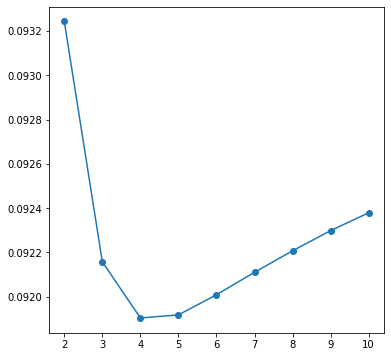

In [72]:
fig,ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(np.arange(2, 11), diffusion_mcv["mcv_loss"], marker="o")

plt.show()

In [57]:
opt_diffusion = diffusion(obs_counts, 4, 50, 40, 0.9, sum(map(ord, "optimal")))
too_smooth = diffusion(obs_counts, 10, 50, 40, 0.9, sum(map(ord, "too_smooth")))
not_smooth_enough = diffusion(
    obs_counts, 2, 50, 40, 0.9, sum(map(ord, "not_smooth_enough")),
)

In [73]:
true_dg = calc_diff_genes_mannwhitney_p(true_counts, cell_meta)[0, 1] < np.log(1e-6)
total_p = true_dg.sum()

obs_dg = calc_diff_genes_mannwhitney_p(obs_counts, cell_meta)[0, 1]
opt_dg = calc_diff_genes_mannwhitney_p(opt_diffusion, cell_meta)[0, 1]
ts_dg = calc_diff_genes_mannwhitney_p(too_smooth, cell_meta)[0, 1]
nse_dg = calc_diff_genes_mannwhitney_p(not_smooth_enough, cell_meta)[0, 1]

In [95]:
np.percentile(opt_dg, (20, 50, 95, 99))

array([-320.87949508, -313.83779153,  -12.36919005,   -1.1082295 ])

In [102]:
np.log10(np.exp(-330))

-143.3171790280731

In [93]:
(obs_dg < np.log(1e-30)).sum()

609

(array([ 174.,  175.,  198.,  211.,  240.,  237.,  308.,  600.,  414.,
        3809.]),
 array([1.10461409e-02, 2.53058424e+00, 5.05012233e+00, 7.56966043e+00,
        1.00891985e+01, 1.26087366e+01, 1.51282747e+01, 1.76478128e+01,
        2.01673509e+01, 2.26868890e+01, 2.52064271e+01]),
 <a list of 10 Patch objects>)

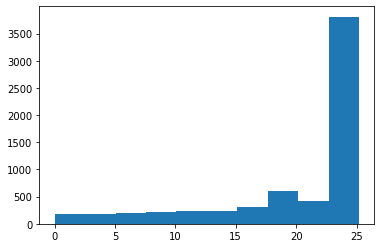

In [106]:
plt.hist(calc_diff_genes_mannwhitney_u(opt_diffusion, cell_meta)[0,1])

for raw:
	1e-100	167	0	precision 1.000	recall: 0.044
	1e-110	139	0	precision 1.000	recall: 0.036
	1e-120	130	0	precision 1.000	recall: 0.034
	1e-130	109	0	precision 1.000	recall: 0.028
for opt:
	1e-100	3328	698	precision 0.827	recall: 0.868
	1e-110	3249	614	precision 0.841	recall: 0.848
	1e-120	3167	529	precision 0.857	recall: 0.826
	1e-130	3045	405	precision 0.883	recall: 0.795
for smooth:
	1e-100	3694	1476	precision 0.715	recall: 0.964
	1e-110	3673	1418	precision 0.721	recall: 0.959
	1e-120	3655	1339	precision 0.732	recall: 0.954
	1e-130	3627	1245	precision 0.744	recall: 0.947
for not:
	1e-100	2862	193	precision 0.937	recall: 0.747
	1e-110	2679	136	precision 0.952	recall: 0.699
	1e-120	2453	89	precision 0.965	recall: 0.640
	1e-130	2174	38	precision 0.983	recall: 0.567


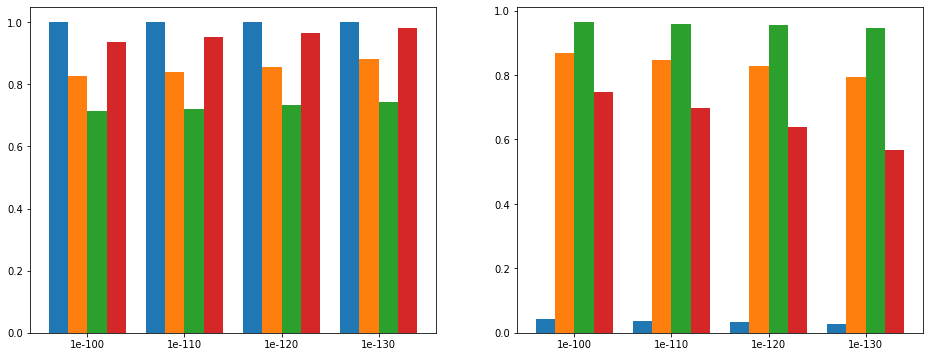

In [104]:
cutoffs = 10.**(np.arange(-100, -131, -10))
fig,ax = plt.subplots(1, 2, figsize=(16, 6))

for i,(lbl,dg) in enumerate(zip(("raw", "opt", "smooth", "not"), (obs_dg, opt_dg, ts_dg, nse_dg))):
    precision = []
    recall = []

    print(f"for {lbl}:")
    
    for cutoff in cutoffs:
        logp = np.log(cutoff)
        tp = (true_dg & (dg < logp)).sum()
        fp = ((~true_dg) & (dg < logp)).sum()
        
        precision.append(tp / (tp + fp))
        recall.append(tp / total_p)
        print(f"\t{cutoff}\t{tp}\t{fp}\tprecision {tp / (tp + fp):.3f}\trecall: {tp / total_p:.3f}")

    ax[0].bar(np.arange(1, 5) + i * 0.2 + 0.2, precision, width=0.2)
    ax[1].bar(np.arange(1, 5) + i * 0.2 + 0.2, recall, width=0.2)

ax[0].set_xticks(np.arange(1, 5) + 0.5)
ax[1].set_xticks(np.arange(1, 5) + 0.5)
ax[0].set_xticklabels(cutoffs)
ax[1].set_xticklabels(cutoffs)

plt.show()

Raw counts
0.9685846859876702
Optimal Diffusion
0.9200625795209294
Too Smooth
0.8746731712371217
Not Smooth Enough
0.9533658034022241


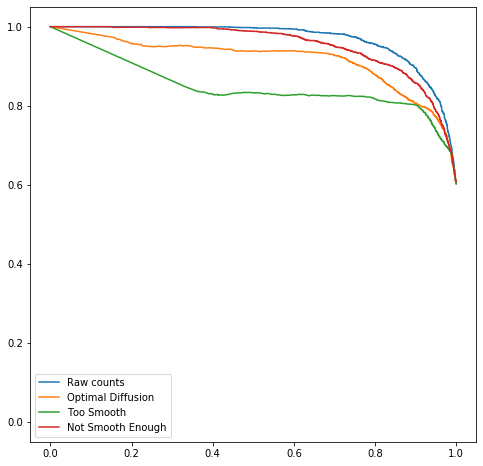

In [108]:
fig,ax = plt.subplots(1, 1, figsize=(8, 8))

for z,(lbl,d) in enumerate(zip(
    ("Raw counts", "Optimal Diffusion", "Too Smooth", "Not Smooth Enough"), 
    (obs_counts, opt_diffusion, too_smooth, not_smooth_enough)
)):
    mannwhitney_up = calc_diff_genes_mannwhitney_up(d, cell_meta)[0, 1]
    print(lbl)
    print(plot_prc(true_dg, mannwhitney_up, ax=ax, label=lbl))

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.legend()
plt.show()